# Introduction

<center><img src="https://i.imgur.com/Hh0CekB.jpg" width="500px"></center> 

Many participants in Kaggle competitions often try to increase their scores on the public leaderboard (LB) again and again, so that they stay ahead in the race for a medal. Some of these participants succeed in their endeavour and manage to stay at the top of the public LB. But, suddenly, when the private LB is revealed, a lot of these "table toppers" drop to low positions on the new leaderboard and miss out on a medal. But, on the other hand, many people who were low on the public LB jump up to high positions on the private LB. This phenomenon is called a **shakeup**.

Shakeups are most often caused by something called **overfitting** in machine learning. So, in this kernel, I will be explaining the most effective methods to identify and reduce overfitting, so that you can ensure a high place on the private LB and possibly even win a medal! Additionally, I will  be suggesting articles, blogs, and videos that explain these methods in greater detail.



<font size="3" color="red"> Please upvote this kernel if you like it. It motivates me to produce more quality content :) </font>

# Acknowledgements

* [@tearth](https://www.kaggle.com/tearth) for the meme above :)

# Import libraries and prepare the data

#### (Click CODE on the right side)

In [1]:
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import SVG

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Dropout, BatchNormalization
import tensorflow as tf

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go

Using TensorFlow backend.


In [2]:
DATA_PATH = '../input/ieee-fraud-detection/'
TRAIN_PATH = DATA_PATH + 'train_transaction.csv'
train_df = pd.read_csv(TRAIN_PATH)
train_df = train_df.fillna(0.0)

In [3]:
cat_cols = ['DeviceType', 'DeviceInfo', 'ProductCD', 
            'card4', 'card6', 'M4', 'P_emaildomain',
            'R_emaildomain','card1', 'card2', 'card3', 'card5', 'addr1',
            'addr2', 'M1', 'M2', 'M3', 'M5', 'M6','M7', 'M8', 'M9', 
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3',
            'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

cat_cols = [col for col in cat_cols if col in train_df.columns]

In [4]:
def prepare_data(df, cat_cols=cat_cols):
    cat_cols = [col for col in cat_cols if col in df.columns]
    for col in tqdm(cat_cols):\
        df[col] = pd.factorize(df[col])[0]
    return df

train_data = prepare_data(train_df)

In [5]:
X = train_data.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_data.sort_values('TransactionDT')['isFraud']
del train_data

# What is overfitting?

<center><img src="https://i.imgur.com/dJVkotI.jpg" width="500px"></center>

Overfitting is the tendency of a machine learning model to perform really well on the known training data, and then perform significantly worse on the testing data. **This happens when the model memorizes the data instead of understanding the hidden patterns in the data.** This means that the model learns the training data so precisely, that it loses the ability to adapt and use its knowledge on new data.

This is one form of overfitting, but the main type of overfitting that causes shakeups is **test data overfitting**. This happens when the model performs very well on the public test data, but underperforms on the private test data. This is a result of **public LB probing**, where the participant tries to increase the the public LB score as much as possible, but the model performs poorly on the private LB because it is essentially memorizing the public test data.

On the other hand, underfitting is when the model is not even able to fit the training data properly. Therefore, both the training and testing accuracis are low in the case of underfitting.

## A video explaining overfitting

Here is a video by Udacity explaining what overfitting is:

In [6]:
from IPython.display import HTML
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/mfzHchd5La8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

## Resources for understanding overfitting

* [Overfitting and Underfitting With Machine Learning Algorithms](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/) ~ by Machine Learning Mastery
* [Overfitting vs. Underfitting](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765) ~ by Will Koehrsen
* [Overfitting vs. Underfitting: A Conceptual Explanation](https://towardsdatascience.com/overfitting-vs-underfitting-a-conceptual-explanation-d94ee20ca7f9) ~ by Will Koehrsen

### Takeaways from this section

* Overfitting is when a model's accuracy is significantly higher on the training data than the testing data.
* Overfitting can also happen when one fits the private test data significantly worse than the public test data.
* When a model overfits, it tends to memorize the data instead of understanding patterns in the data.

# How can we identify overfitting?

Overfitting is a fairly simple concept to understand, but understanding how to identify and correct overfitting are very difficult tasks. A data scientist can get better at these things only by continuous practice. But, I can give some tips regarding how you can identify if your model is overfitting or not.

## Validation

Validation is a way of checking how your model performs on new, unseen data. In validation, one samples a small percentage of the data points in the training data (usually around 20%) and sets in aside. The remaining samples are used to train the model and the chosen samples are used to evaluate the model. After each iteration of training, the model's performance is evaluated on this validation data to check how the model performs on data that it has never seen before.

Note that the validation samples need to be selected randomly so that the validation score actually reflects how well the model may do on unseen data (*i.e.* the public and private testing datasets).

### Demonstration

Now, I will demonstrate how you can add validation to a neural network model.

### Build neural network

In [7]:
def get_neural_network():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(10, activation='relu')(inputs)
    dense_2 = Dense(10, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = get_neural_network()

### Visualize the model architecture

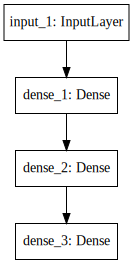

In [8]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Split the data into training and validation sets

In [9]:
split = np.int32(0.8 * len(X))

X_train = X[:split]
y_train = np.int32(y)[:split]

X_val = X[split:]
y_val = np.int32(y)[split:]

### Train the model

In [10]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 32s 67us/step - loss: 0.5763 - acc: 0.9439 - val_loss: 0.2088 - val_acc: 0.9629
Epoch 2/5
472432/472432 [==============================] - 31s 65us/step - loss: 0.4057 - acc: 0.9516 - val_loss: 0.1226 - val_acc: 0.9681
Epoch 3/5
472432/472432 [==============================] - 30s 64us/step - loss: 0.1705 - acc: 0.9669 - val_loss: 0.1978 - val_acc: 0.9653
Epoch 4/5
472432/472432 [==============================] - 32s 67us/step - loss: 0.1466 - acc: 0.9688 - val_loss: 0.1135 - val_acc: 0.9707
Epoch 5/5
472432/472432 [==============================] - 30s 64us/step - loss: 0.1131 - acc: 0.9713 - val_loss: 0.1130 - val_acc: 0.9712


### Plot the loss and accuracy statistics 

### Accuracy

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=history.history['acc'],
    name='train', mode='lines+markers',
    marker_color='crimson'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=history.history['val_acc'],
    name='val', mode='lines+markers',
    marker_color=' indigo'
))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Accuracy over the epochs',
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))


fig.show()

In the plot above, we can see how the validation and training accuracies are changing. The training accuracy ends up just above the validation accuracy at the last epoch. This shows that the model is learning well because the gap between the training and validation accuracies is small. This means that the data performs at almost the same level on unseen data. In this way, we can use validation to check whether our model is overfitting or not.

In [12]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=history.history['acc']*100, marker={'color' : 'crimson'}),
    go.Bar(name='val', x=labels, y=history.history['val_acc']*100, marker={'color' : 'indigo'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can see the same insight in the bar plot above. The training accuracy is initially lower than the validation accuracy, but it eventually catches up, and ends up just above the validation accuracy at the end. This is a sign of a model that is not overfitting (training accuracy only just above validation accuracy).

### Loss

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=history.history['loss'],
    name='train', mode='lines+markers',
    marker_color='crimson'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=history.history['val_loss'],
    name='val', mode='lines+markers',
    marker_color=' indigo'
))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Styled Scatter',
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))


fig.show()

In the plot above, we can see how the validation and training losses are changing. The losses end up in close proximity towards the last few epochs. This shows that the training and validation losses are both decreasing together in sync with each other. Once again, it is an indication that there is no clear overfitting.

In [14]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=history.history['loss'], marker={'color' : 'crimson'}),
    go.Bar(name='val', x=labels, y=history.history['val_loss'], marker={'color' : 'indigo'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can observe the same insight from the bar plot above. The losses get closer and closer to each other as the epochs increase. This is a sign of healthy training without overfitting.

### Cross validation

Cross validation is a special type of validation that makes use of the entire training data to evaluate the model properly, so that as much randomness as possible can be introduced. In cross validation, the training dataset is divided into a certain number of **folds**. These folds are subsets of the original training data. Each fold has an equal number of randomly selected data samples. 

One fold is selected and set aside. The remaining folds are used to train the model, and the selected fold is used to evaluate the performance of the model at each iteration. Now, the next fold is selected and the same process repeats. We repeat this process until each fold has acted as a validation set once. 

This process is called **cross-validation**. Cross validation is helpful because the entire training dataset is being used to validate the model. This means that we are introducing more randomness and variety into our validation set instead of restricting ourselves to one fixed validation set. **This gives a more reliable idea of how the model would perform on real testing data.**

### Types of cross validation

There are many types of cross validation that are used for different types of data. Here are a few common types of cross validation:

* **Time-series split** : For data with a time dimension
* **Stratified K-Fold** : For data with a categorical target (like this competition)
* **K-Fold** : For data with a continuous target

Cross validation is a very good way to diagnose overfitting. In fact, the gap between your cross validation score and public LB score can be used as a way to determine whether your model is overfitting or not. So, **looking at only the public LB score or only the cross validation score may not be that useful, but looking at them together will give a clearer picture**.

Let me illustrate this point with a simple example. Assume that the statistics given below are the accuracy scores for two different models. The first row corresponds to the first and the second one to the second model.

|        | Public LB Score   |  Cross Validation Score    |
| ------ | ------ |------|
|Model 1 | 97 %  |  97.5 %    |
| Model 2 | 97.5 % | 99 %

From the above table of scores, it may look like model 2 is a better choice for private LB submission because it has a higher CV and public LB score as compared to model 2. But, this is actually a misleading illusion.

If you look at the numbers closely, the error percentage in model 1 is 2.5% for cross validation and 3% for public LB. These error percentages are somewhat similar. But, if you look at the error percentages in model 2, they are 1% for cross validation and 2.5% for public LB. This is a comparatively massive gap between the CV and public LB scores. The public LB error percentage for model 2 is 2.5 times larger than the cross validation error. This shows that model 2 is overfitting to the cross validation data, and is not improving much on its test data performance. So, model 1 is more likely to perform better on a new private test dataset because it has very good CV and LB accuracies, and at the same, the gap between CV and LB is not very large. To summarize, **never go for a very small increase in LB score when the increase in CV score is very large, because this may lead to overfitting**.

So, look for an increase in CV score, but make sure that the gap between CV and LB remains small. This idea is excellently explained by [@cpmpml](https://kaggle.com/cpmpml) in his talk at Kaggle days:

In [15]:
from IPython.display import YouTubeVideo
YouTubeVideo("VC8Jc9_lNoY", start=60*9, width=700, height=400)

### Resources for understanding validation

* [About Train, Validation and Test Sets in Machine Learning](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) ~ by Tarang Shah
* [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/) ~ by Machine Learning Mastery
* [Cross-Validation in Machine Learning](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f) ~ by Prashant Gupta
* [A Gentle Introduction to k-fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/) ~ by Machine Learning Mastery

### Takeaways from this section

* Always create a robust and reliable validation system for your models.
* When choosing which models to submit to the private LB, look at the CV and public LB scores together.
* The gap between CV and public LB scores should be as small as possible, and never go far a change that shows a huge improvement in CV, but a relatively small improvement in public LB.

# How to reduce overfitting?

Now, because we understand how validation can be used to detect overfitting, the next step is to understand how to fix overfitting. There are many ways to reduce overfitting, but the most most common ones are as follows:

* **Reducing model complexity**
* **Ensembling**
* **Regularization**

I will look at these differrent methods one-by-one, explain them, and then demonstrate how they work with a simple neural network model.

## Reducing model complexity

In the above diagram, the data can be easily modeled using a simple linear function. This is because the general trend in the data seems to be linear. But, instead, a highe degree polynomial is used and the data is fit perfectly without any error. This model may achieve 100% accuracy on the training data, but it will surely fail badly when tested on new data. This is because the model has **fitted the noise** in the training data, and in the process, it memorizes the data instead of finding the required pattern. Therefore, an overly complex model may lead to overfitting. But, at the same time, an overly simple model may lead to underfitting.

So, when a model starts overfitting, one way to reduce the overfitting is to reduce the complexity of the model. In a neural network, this can be done by reducing the number of layers in the network or reducing the number of neurons in the each layer. This can also be done for a gradient boosting model like LightGBM by reducing paramters like *max_depth*. By doing this, we are intentionally, reducing the complexity of the model in order to prevent overfitting from taking place.

<center><img src="https://i.imgur.com/k6ZQvak.png" width="800px"></center>

The idea that reducing model complexity can reduce overfitting can be understood using the concepts of **variance and bias**.

**Variance** is the amount that the estimate of the model will change if different training data was used. This quantity measures the capacity of a model to fit different datasets, and is therefore also a measure of the complexity of the model. A high variance means that the model has a very complex target function and is able to fit the training data very accurately. On the other hand, a low variance means that the model has a low level of complexity and is therefore unable to fit the training very closely. It may look like the more the variance the better, but in fact, the variance of any model should be moderate, and the "moderate" level of variance depends on the nature of the data. Some datasets demand models with a high variance whereas other datasets require a much lower level of variance. For example, the MNIST dataset can be modeled easily using a simple CNN, but a self-driving car dataset involving complex video and sensor data may require a more complex (high variance) model.

This brings me to the concept of bias. **Bias** are the simplifying assumptions made by a model to make the target function easier to learn.  This quantity measures the simplicity of the model, because simpler models often tend to make more assumptions to fit the data. A high bias means that the model has a simple target function and is therefore unable to fit the training very closely. On the other hand, a low bias means that the model has a high level of complexity and is therefore able to fit the training very closely.

**Models with a high variance tend to have a low bias and vice-versa, and therefore, there is a direct tradeoff between them**. Choosing the correct balance of variance and bias (for a particular dataset) is the key to avoiding overfitting.

### Demonstration

Now, I will demonstrate how the reducing the model complexity may help prevent a model from overfitting. Once again, I will use neural network models to demonstrate this idea. Specifically, I will build and train a very complex neural network model (with several neurons). Then, I will show how reducing the complexity of the model (by removing neurons) can help reduce overfitting in the model.

### Build model #1

First, we will build a model with two hidden layers (100 neurons each) and a single-neuron layer with a sigmoid activation at the end to output the probability.

In [16]:
def get_model_one():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(100, activation='relu')(inputs)
    dense_2 = Dense(100, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model_one = get_model_one()

### Visualize the model architecture

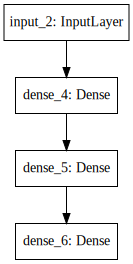

In [17]:
SVG(model_to_dot(model_one).create(prog='dot', format='svg'))

### Train the model and store training history

In [18]:
history = model_one.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 35s 74us/step - loss: 0.3222 - acc: 0.9661 - val_loss: 0.1649 - val_acc: 0.9646
Epoch 2/5
472432/472432 [==============================] - 34s 73us/step - loss: 0.1324 - acc: 0.9702 - val_loss: 0.1183 - val_acc: 0.9702
Epoch 3/5
472432/472432 [==============================] - 33s 71us/step - loss: 0.1381 - acc: 0.9700 - val_loss: 0.1208 - val_acc: 0.9698
Epoch 4/5
472432/472432 [==============================] - 33s 71us/step - loss: 0.1207 - acc: 0.9716 - val_loss: 0.1176 - val_acc: 0.9709
Epoch 5/5
472432/472432 [==============================] - 33s 71us/step - loss: 0.1193 - acc: 0.9717 - val_loss: 0.1152 - val_acc: 0.9707


In [19]:
train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

train_acc_1 = history.history['acc']
val_acc_1 = history.history['val_acc']

### Visualize the training and validation statistics for model #1

### Accuracy

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_acc_1,
    name='train', mode='lines+markers',
    marker_color='blue'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_acc_1,
    name='val', mode='lines+markers',
    marker_color=' fuchsia'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the training and validation accuracies for the 100-neuron model diverge towards the last few epochs. The training accuracy ends up significantly higher than the validation accuracy. This indicates that the model is not able to replicate its training performance when faced with the unseen validation data. This is a clear sign of overfitting.

In [21]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_acc_1)*100, marker={'color' : 'blue'}),
    go.Bar(name='val', x=labels, y=np.array(val_acc_1)*100, marker={'color' : 'fuchsia'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can observe the same fact from the bar plot above. The training and validation accuracies diverge towards the end, with the training accuracy ending up significantly higher than the validation accuracy. This is, once again, a clear indication of overfitting.

### Loss

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_loss_1,
    name='train', mode='lines+markers',
    marker_color='blue'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_loss_1,
    name='val', mode='lines+markers',
    marker_color=' fuchsia'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the validation loss spikes clearly higher than the training loss towards the end of the training process. This indicates that the model is overfitting, as it is unable to replicate its training performance on the unseen validation data.

In [23]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_loss_1), marker={'color' : 'blue'}),
    go.Bar(name='val', x=labels, y=np.array(val_loss_1), marker={'color' : 'fuchsia'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can once again observe the same insight from the above bar plot. Towards the last few epochs, the validation loss rises clearly higher above the training loss. Once, again, this indicates that the model is overfitting.

In general, we can conclude that this 100-neuron model (model #1) is overfitting. Now, let us decrease the complexity of the model by decreasing the number of neurons in each hidden layer. This should help reduce the overfitting.

### Build model #2

Now, we build another model. The architecture is the same as last time, but this time, there are 10 neurons in each hidden layer instead of 100.

In [24]:
def get_model_two():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(10, activation='relu')(inputs)
    dense_2 = Dense(10, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model_two = get_model_two()

### Visualize the model architecture

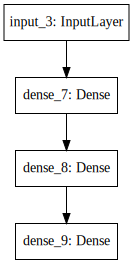

In [25]:
SVG(model_to_dot(model_two).create(prog='dot', format='svg'))

### Train the model and store training history

In [26]:
history = model_two.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 31s 65us/step - loss: 0.2638 - acc: 0.9594 - val_loss: 0.2037 - val_acc: 0.9642
Epoch 2/5
472432/472432 [==============================] - 31s 65us/step - loss: 0.2936 - acc: 0.9583 - val_loss: 0.1182 - val_acc: 0.9703
Epoch 3/5
472432/472432 [==============================] - 30s 62us/step - loss: 0.1145 - acc: 0.9707 - val_loss: 0.1123 - val_acc: 0.9710
Epoch 4/5
472432/472432 [==============================] - 31s 65us/step - loss: 0.1113 - acc: 0.9714 - val_loss: 0.1108 - val_acc: 0.9709
Epoch 5/5
472432/472432 [==============================] - 30s 64us/step - loss: 0.1093 - acc: 0.9715 - val_loss: 0.1109 - val_acc: 0.9708


In [27]:
train_loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

train_acc_2 = history.history['acc']
val_acc_2 = history.history['val_acc']

### Visualize the training and validation statistics for model #2

### Accuracy

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_acc_2,
    name='train', mode='lines+markers',
    marker_color='green'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_acc_2,
    name='val', mode='lines+markers',
    marker_color='red'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the training accuracy rises above the validation accuracy towards the end of the training process. But, the gap between the training and validation accuracies is very small compared to the 100-neuron model. This indicates that the model is training properly and is able to successfully avoid overfitting.

In [29]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_acc_2)*100, marker={'color' : 'green'}),
    go.Bar(name='val', x=labels, y=np.array(val_acc_2)*100, marker={'color' : 'red'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

In the bar plot above, we can observe the same insight. The training accuracy ends up just above the validation accuracy at the end, but the gap between the two accuracies is significantly smaller than it was in the case of the 100-neuron model.

### Loss

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_loss_2,
    name='train', mode='lines+markers',
    marker_color='green'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_loss_2,
    name='val', mode='lines+markers',
    marker_color='red'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the training loss ends up below the validation loss towards the end of the training process. But, the gap between the two losses is much smaller compared to the 100-neuron model. This shows that the model is learning properly. It is not overfitting.

In [31]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_loss_2), marker={'color' : 'green'}),
    go.Bar(name='val', x=labels, y=np.array(val_loss_2), marker={'color' : 'red'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can observe the same insight from the bar plot above. The validation loss ends up just above the training loss at the end of the training process, but the gap is much smaller compared to the 100-neuron model. This once again indicates that the model is not overfitting.

### Make predictions on training and validation data from the models 

In [32]:
preds_one_val = model_one.predict(X_val)
preds_two_val = model_two.predict(X_val)

preds_one_train = model_one.predict(X_train)
preds_two_train = model_two.predict(X_train)

### Visualize training and validation accuracy for both the models

In [33]:
import plotly.graph_objects as go
labels=['100-Neuron Model', '10-Neuron Model']

fig = go.Figure(data=[
    go.Bar(name='val', x=labels, y=[accuracy_score(y_val, np.round(preds_one_val))*100, accuracy_score(y_val, np.round(preds_two_val))*100]),
    go.Bar(name='train', x=labels, y=[accuracy_score(y_train, np.round(preds_one_train))*100, accuracy_score(y_train, np.round(preds_two_train))*100])
])
# Change the bar mode
fig.update_layout(barmode='group', yaxis_title="Accuracy", yaxis_type="log")
fig.show()

We can see from the above plot that the training accuracy ends up higher than the validation accuracy in both cases. But, in the case of the second model, the gap is much smaller. Thus, we can conclude that we have been able to reduce overfitting by reducing the complexity of the model.

## Ensembling

Ensembling is a very useful and common method used to reduce overfitting. In ensembling, the outputs from several models are combined (most commonly by averaging) to form one prediction vector. This final prediction usually has a greater accuracy than the other individual prediction vectors. This is because, when the predictions from different models are combined by averaging, the errors in the different prediction vectors are partially "canceled out" or reduced in magnitude. But, note that **this works only when the correlation between the different prediction vectors is considerably low, otherwise the ensemble would score similarly to the individual models**.

This implies that the **variety in the models is very important**. This means that one must ensemble models which are very different from each other in terms of architecture, hyperparameters, or algorithm in order to achieve maximum benefits from ensembling. For example, it might be a better idea to ensemble a LightGBM model with a Neural Network model instead of ensembling two LightGBM models. When more diverse models are selected, the diversity in predictions is also greater, and therefore, there is a higher chance of the ensemble to effectively reduce the errors in the predictions by "canceling them out".

### A video explaining ensembling

Here is another video by Udacity explaining what ensembling is:

In [34]:
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/Un9zObFjBH0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

### Demonstration

Now, I will demonstrate how ensembling can be used to help a model generalize better and avoid overfitting. I will build and train two separate neural network models, and then show how ensembling them can increase the cross validation score.

### Build model #1

First, we will build a model with two hidden layers (20 neurons each) and a single-neuron layer with a sigmoid activation at the end to output the probability.

In [35]:
def get_model_one():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(20, activation='relu')(inputs)
    dense_2 = Dense(20, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model_one = get_model_one()

### Visualize model architecture

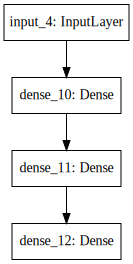

In [36]:
SVG(model_to_dot(model_one).create(prog='dot', format='svg'))

### Train the model and store training history

In [37]:
history = model_one.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 32s 67us/step - loss: 0.1832 - acc: 0.9659 - val_loss: 0.1192 - val_acc: 0.9695
Epoch 2/5
472432/472432 [==============================] - 31s 66us/step - loss: 0.1200 - acc: 0.9702 - val_loss: 0.1191 - val_acc: 0.9699
Epoch 3/5
472432/472432 [==============================] - 31s 65us/step - loss: 0.1148 - acc: 0.9709 - val_loss: 0.1150 - val_acc: 0.9705
Epoch 4/5
472432/472432 [==============================] - 31s 66us/step - loss: 0.1142 - acc: 0.9715 - val_loss: 0.1143 - val_acc: 0.9710
Epoch 5/5
472432/472432 [==============================] - 31s 66us/step - loss: 0.1100 - acc: 0.9719 - val_loss: 0.1114 - val_acc: 0.9714


In [38]:
train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

train_acc_1 = history.history['acc']
val_acc_1 = history.history['val_acc']

### Visualize the training and validation statistics for model #1

### Accuracy

In [39]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_acc_1,
    name='train', mode='lines+markers',
    marker_color='orangered'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_acc_1,
    name='val', mode='lines+markers',
    marker_color='navy'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the training and validation accuracies for the 10-neuron model slightly diverge towards the last few epochs. The training accuracy ends up slightly higher than the validation accuracy. This indicates that the model is overfitting, but not as much as the previous 100-neuron model.

In [40]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_acc_1)*100, marker={'color' : 'orangered'}),
    go.Bar(name='val', x=labels, y=np.array(val_acc_1)*100, marker={'color' : 'navy'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can see the same insight from the above bar plot. The training accuracy ends up slightly higher than the validation accuracy towards the last few epochs. This indicates that the model is overfitting, but only slightly.

### Loss

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_loss_1,
    name='train', mode='lines+markers',
    marker_color='orangered'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_loss_1,
    name='val', mode='lines+markers',
    marker_color=' navy'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the validation loss ends up slightly higher than the training loss towards the end. This once again shows that the model is overfitting, but not very heavily.

In [42]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_loss_1), marker={'color' : 'orangered'}),
    go.Bar(name='val', x=labels, y=np.array(val_loss_1), marker={'color' : 'navy'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can see the same insight from the above bar plot. The training accuracy ends up slightly higher than the validation accuracy towards the last few epochs. This indicates that the model is overfitting, but only slightly.

We can conclude that this model is overfitting only slightly. So, now I will build another model with 25 neurons instead of 10 neurons in each layer.

### Build model #2

Now, we will build a new model with the same architecture, but with 25 (instead of 20) neurons per hidden layer, and a single-neuron layer with a sigmoid activation at the end to output the probability.

In [43]:
def get_model_two():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(25, activation='relu')(inputs)
    dense_2 = Dense(25, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model_two = get_model_two()

### Visualize the model architecture

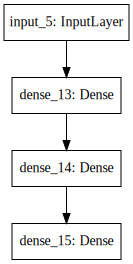

In [44]:
SVG(model_to_dot(model_two).create(prog='dot', format='svg'))

### Train the model and store training history

In [45]:
history = model_two.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 32s 69us/step - loss: 0.2359 - acc: 0.9655 - val_loss: 0.1317 - val_acc: 0.9691
Epoch 2/5
472432/472432 [==============================] - 31s 66us/step - loss: 0.2719 - acc: 0.9603 - val_loss: 0.2086 - val_acc: 0.9633
Epoch 3/5
472432/472432 [==============================] - 30s 63us/step - loss: 0.1658 - acc: 0.9677 - val_loss: 0.1202 - val_acc: 0.9700
Epoch 4/5
472432/472432 [==============================] - 32s 67us/step - loss: 0.1201 - acc: 0.9710 - val_loss: 0.1196 - val_acc: 0.9701
Epoch 5/5
472432/472432 [==============================] - 31s 65us/step - loss: 0.1187 - acc: 0.9713 - val_loss: 0.1164 - val_acc: 0.9706


In [46]:
train_loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

train_acc_2 = history.history['acc']
val_acc_2 = history.history['val_acc']

### Visualize the training and validation statistics for model #2

### Accuracy

In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_acc_2,
    name='train', mode='lines+markers',
    marker_color='darkmagenta'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_acc_2,
    name='val', mode='lines+markers',
    marker_color='limegreen'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(titlefont=dict(size=18), yaxis_zeroline=False, xaxis_zeroline=False)

fig.show()

In the above plot, we can see that the training and validation accuracies for the 25-neuron model are similar towards the last few epochs. The training accuracy ends up only slightly higher than the validation accuracy. This indicates that the model is able to replicate its training performance when faced with the unseen validation data. This is not overfitting.

In [48]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_acc_2)*100, marker={'color' : 'purple'}),
    go.Bar(name='val', x=labels, y=np.array(val_acc_2)*100, marker={'color' : 'limegreen'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can observe the same fact from the bar plot above. The training and validation accuracies diverge by a very small margin, with the training accuracy ending up only slightly higher than the validation accuracy. This is, once again, an indication of no overfitting.

### Loss

In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_loss_2,
    name='train', mode='lines+markers',
    marker_color='darkmagenta'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_loss_2,
    name='val', mode='lines+markers',
    marker_color='limegreen'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the validation loss ends up just above the training loss, but since the gap is very small, we can say that the model is not overfitting.

In [50]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_loss_2), marker={'color' : 'darkmagenta'}),
    go.Bar(name='val', x=labels, y=np.array(val_loss_2), marker={'color' : 'limegreen'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can once again observe the same insight from the above bar plot. Towards the last few epochs, the validation loss ends up near the training loss. Once, again, this indicates that the model is not overfitting.

In general, we can conclude that this 25-neuron model (model #2) is now overfitting. Now, let us ensemble the two models and see what happens.

### Ensembling the two models

Now, I will ensemble the two models by averaging their predictions on the validation data.

In [51]:
preds_one = model_one.predict(X_val)
preds_two = model_two.predict(X_val)

In [52]:
ensemble = 0.75 * preds_one + 0.25 * preds_two

I give a higher weightage (75 %) to the first model than the second model (25 %) because the second model has a better CV score than the first model. **The model weightages in the ensemble can be decided based on the individual cross validation scores**.

### Check the accuracy values for model #1, model #2, and their ensemble

In [53]:
print("Accuracy of the first model : " + str(accuracy_score(y_val, np.round(preds_one))*100) + " %")
print("Accuracy of the second model : " + str(accuracy_score(y_val, np.round(preds_two))*100) + " %")
print("Accuracy of the average ensemble : " + str(accuracy_score(y_val, np.round(ensemble))*100) + " %")

Accuracy of the first model : 97.13821248348968 %
Accuracy of the second model : 97.06201104074236 %
Accuracy of the average ensemble : 97.13313238730653 %


The accuracy of models #1 and #2 are both very high. Therefore, the ensemble's accuracy was higher than the accuracies of the two models. Therefore, **ensembling is effective only when several models with strong generalization are combined together**. Even one weak model can bring down the accuracy of the ensemble by a lot. 

### Visualize the accuracy for model #1, model #2, and their ensemble

In [54]:
acc_1 = accuracy_score(y_val, np.round(preds_one))*100
acc_2 = accuracy_score(y_val, np.round(preds_two))*100
acc_ensemble = accuracy_score(y_val, np.round(ensemble))*100

### Difference of the accuracies of the models above 96.9 %

In [55]:
labels=['Model 1', 'Model 2', 'Ensemble']

fig = go.Figure(data=[go.Bar(x=labels, y=[acc_1 - 96.9, acc_2 - 96.9, acc_ensemble - 96.9], marker={'color' : 'crimson'})])
# Change the bar mode
fig.update_layout(title="Accuracy for different models (above 96.9)", yaxis=dict(title="Accuracy (above 96.9)"))
fig.show()

We can once again see from the above plot that the ensemble accuracy is greater than the individual accuracies of model #1 and model #2.

### Resources for understading ensembling

* [A Comprehensive Guide to Ensemble Learning (with Python codes)](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/) ~ by Aishwarya Singh
* [Ensemble Learning Methods for Deep Learning Neural Networks](https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/) ~ by Machine Learning Mastery

## Regularization

Regularization is another great way to prevent models from overfitting. **Regularization is a group of methods aimed at improving the generalization of models**. Basically, regularization methods ensure that the model maintains the same performance level on the validation data (and testing data) as it does on the training data.

Regularization can take on many different types and forms based on the data and model under consideration. For example, a method called [Dropout](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) can be used to improve the generalization of neural networks. This is a form of regularization. Similarly, one can also use the [L1 and L2 methods](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) to reduce overfitting in a neural network. Once, this is a form of regularization.

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

The probablity of dropping a random neuron is called the dropout rate. For the demonstration below, I will use a dropout rate 0f 0.2.

<center><img src="https://i.imgur.com/qFmZI6M.png" width="600px"></center>

### A video explaining regularization

Here is a video of Andrew Ng explaining the idea of regularization and how it can be used to combat overfitting:

In [56]:
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/u73PU6Qwl1I?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

### Demonstration

Regularization can be done in many ways, but for this kernel, I will demonstrating how **dropout** can be used to regularize neural networks.

### Build model #1 (without dropout)

First, we will build a model with two hidden layers (200 neurons each) and a single-neuron layer with a sigmoid activation at the end to output the probability.

In [57]:
def get_model_one():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(200, activation='relu')(inputs)
    dense_2 = Dense(200, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model_one = get_model_one()

### Visualize model architecture

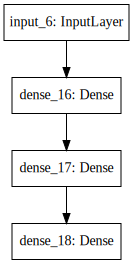

In [58]:
SVG(model_to_dot(model_one).create(prog='dot', format='svg'))

### Train the model and store training history

In [59]:
history = model_one.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 41s 86us/step - loss: 0.4475 - acc: 0.9644 - val_loss: 0.1329 - val_acc: 0.9683
Epoch 2/5
472432/472432 [==============================] - 40s 85us/step - loss: 0.1262 - acc: 0.9701 - val_loss: 0.1202 - val_acc: 0.9699
Epoch 3/5
472432/472432 [==============================] - 40s 85us/step - loss: 0.1179 - acc: 0.9712 - val_loss: 0.1156 - val_acc: 0.9707
Epoch 4/5
472432/472432 [==============================] - 40s 86us/step - loss: 0.1137 - acc: 0.9717 - val_loss: 0.1164 - val_acc: 0.9708
Epoch 5/5
472432/472432 [==============================] - 42s 88us/step - loss: 0.1100 - acc: 0.9723 - val_loss: 0.1162 - val_acc: 0.9710


In [60]:
train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

train_acc_1 = history.history['acc']
val_acc_1 = history.history['val_acc']

### Visualize the training and validation statistics for model #1

### Accuracy

In [61]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_acc_1,
    name='train', mode='lines+markers',
    marker_color='orangered'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_acc_1,
    name='val', mode='lines+markers',
    marker_color='navy'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the training and validation accuracies for the 200-neuron model diverge towards the last few epochs. The training accuracy ends up significantly higher than the validation accuracy. This indicates that the model is not able to replicate its training performance when faced with the unseen validation data. This is a clear sign of heavy overfitting.

In [62]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_acc_1)*100, marker={'color' : 'orangered'}),
    go.Bar(name='val', x=labels, y=np.array(val_acc_1)*100, marker={'color' : 'navy'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can once again observe the same insight from the above bar plot. Towards the last few epochs, the validation loss rises significantly higher above the training loss. Once, again, this indicates that the model is heavily overfitting.

### Loss

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_loss_1,
    name='train', mode='lines+markers',
    marker_color='orangered'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_loss_1,
    name='val', mode='lines+markers',
    marker_color='navy'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the validation loss spikes clearly higher than the training loss towards the end of the training process. This indicates that the model is overfitting, as it is unable to replicate its training performance on the unseen validation data. This time, the overfitting seems to be significant.

In [64]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_loss_1), marker={'color' : 'orangered'}),
    go.Bar(name='val', x=labels, y=np.array(val_loss_1), marker={'color' : 'navy'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can once again observe the same insight from the above bar plot. Towards the last few epochs, the validation loss rises clearly higher above the training loss. Once, again, this indicates that the model is overfitting.

### Build model #2 (with dropout)

Now, we will build a new model with the same architecture, **but with a dropout layer after each hidden layer**, and a single-neuron layer with a sigmoid activation at the end to output the probability.

In [65]:
def get_model_two():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(200, activation='relu')(inputs)
    dense_1 = Dropout(0.2)(dense_1)
    dense_2 = Dense(200, activation='relu')(dense_1)
    dense_2 = Dropout(0.2)(dense_2)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model_two = get_model_two()

### Visualize the model architecture

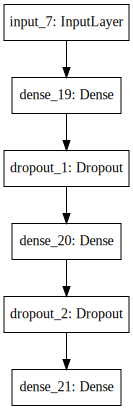

In [66]:
SVG(model_to_dot(model_two).create(prog='dot', format='svg'))

### Train the model and store training history

In [67]:
history = model_two.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 46s 98us/step - loss: 0.4982 - acc: 0.9648 - val_loss: 0.1514 - val_acc: 0.9668
Epoch 2/5
472432/472432 [==============================] - 44s 94us/step - loss: 0.1394 - acc: 0.9679 - val_loss: 0.1196 - val_acc: 0.9690
Epoch 3/5
472432/472432 [==============================] - 45s 95us/step - loss: 0.1278 - acc: 0.9692 - val_loss: 0.1168 - val_acc: 0.9697
Epoch 4/5
472432/472432 [==============================] - 45s 95us/step - loss: 0.1223 - acc: 0.9700 - val_loss: 0.1166 - val_acc: 0.9697
Epoch 5/5
472432/472432 [==============================] - 45s 95us/step - loss: 0.1197 - acc: 0.9706 - val_loss: 0.1137 - val_acc: 0.9706


In [68]:
train_loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

train_acc_2 = history.history['acc']
val_acc_2 = history.history['val_acc']

### Visualize the training and validation statistics for model #1

### Accuracy

In [69]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_acc_2,
    name='train', mode='lines+markers',
    marker_color='brown'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_acc_2,
    name='val', mode='lines+markers',
    marker_color='purple'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(titlefont=dict(size=18), yaxis_zeroline=False, xaxis_zeroline=False)

fig.show()

In the above plot, we can see that the validation accuracy rises above the training accuracy towards the end of the training process. But, the gap between the training and validation accuracies is very small. This indicates that the model is training properly and is able to successfully avoid overfitting.

In [70]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_acc_2)*100, marker={'color' : 'brown'}),
    go.Bar(name='val', x=labels, y=np.array(val_acc_2)*100, marker={'color' : 'purple'})
])
# Change the bar mode
fig.update_layout(title="Accuracy over the epochs", yaxis=dict(title="Accuracy"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

In the bar plot above, we can observe the same insight. The validation accuracy ends up just above the training accuracy at the end, but the gap between the two accuracies is significantly smaller than it was in the case of the no-dropout model.

### Loss

In [71]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=train_loss_2,
    name='train', mode='lines+markers',
    marker_color='brown'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5], y=val_loss_2,
    name='val', mode='lines+markers',
    marker_color='purple'
))

# Set options common to all traces with fig.update_traces
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), xaxis=dict(title="Epochs"))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

In the above plot, we can see that the validation loss ends up below the training loss towards the end of the training process. But, the gap between the two losses is much smaller compared to the no-dropout model. This shows that the model is learning properly. It is not overfitting.

In [72]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=np.array(train_loss_2), marker={'color' : 'brown'}),
    go.Bar(name='val', x=labels, y=np.array(val_loss_2), marker={'color' : 'purple'})
])
# Change the bar mode
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="Loss"), yaxis_type="log")
fig.update_layout(barmode='group')
fig.show()

We can observe the same insight from the bar plot above. The validation loss ends up just below the training loss at the end of the training process, but the gap is much smaller compared to the no-dropout model. This once again indicates that the model is not overfitting.

We can easily conclude that adding dropout to the neural network acted as a regularizer. It helped reduce the gap between training and validation scores. Thus, adding dropout helped successfully remove overfitting from the model.

### Make predictions on training and validation data from the models 

In [73]:
preds_one_val = model_one.predict(X_val)
preds_two_val = model_two.predict(X_val)

preds_one_train = model_one.predict(X_train)
preds_two_train = model_two.predict(X_train)

### Visualize the training and validation accuracy for both the models

In [74]:
import plotly.graph_objects as go
labels=['Without Dropout', 'With Dropout']

fig = go.Figure(data=[
    go.Bar(name='val', x=labels, y=[accuracy_score(y_val, np.round(preds_one_val))*100, accuracy_score(y_val, np.round(preds_two_val))*100]),
    go.Bar(name='train', x=labels, y=[accuracy_score(y_train, np.round(preds_one_train))*100, accuracy_score(y_train, np.round(preds_two_train))*100])
])
# Change the bar mode
fig.update_layout(barmode='group', yaxis_title="Accuracy", yaxis_type="log")
fig.show()

We can see from the above plot that the training accuracy ends up higher than the validation accuracy in both cases. But, in the case of the second model, the gap is much smaller. Thus, we can conclude that we have been able to reduce overfitting by adding dropout to the model.

### Resources for understanding regularization

* [Dropout in (Deep) Machine Learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) ~ by Amar Budhiraja
* [L1 and L2 Regularization Methods](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) ~ by Anuja Nagpal
* [A Gentle Introduction to Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) ~ by Machine Learning Mastery

# Conclusion

From this kernel, I hope you understand that you have a certain degree of control over your public LB standings and it is not completely random. So, using these tips and tricks, you can survive a shakeup and end up with a medal :)

Thanks for reading this kernel. I hope you found it useful.

<font size="4" color="red"> Please upvote this kernel if you liked it. It motivates me to produce more quality content :) </font>